In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing and model building
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load the dataset
df = pd.read_csv("diabetes.csv")

# Preview the data
print("First 5 rows of the dataset:")
display(df.head())


First 5 rows of the dataset:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# List of columns where zero values are invalid and should be treated as missing
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zeros with NaN
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Impute missing values with median
for col in cols_with_zero:
    df[col].fillna(df[col].median(), inplace=True)


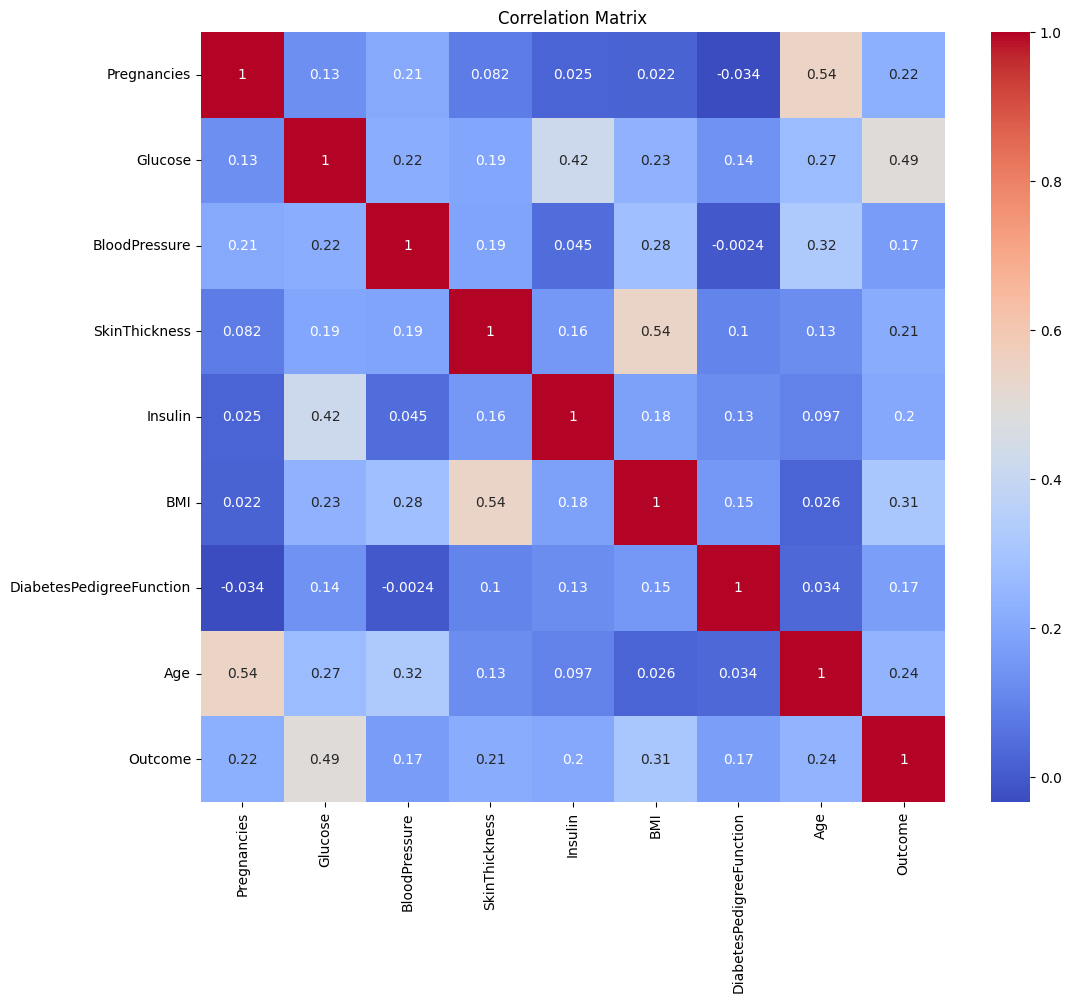

In [5]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


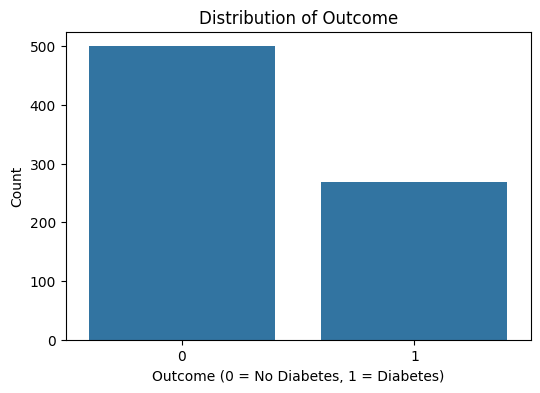

In [6]:
# Outcome distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Outcome", data=df)
plt.title("Distribution of Outcome")
plt.xlabel("Outcome (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Count")
plt.show()


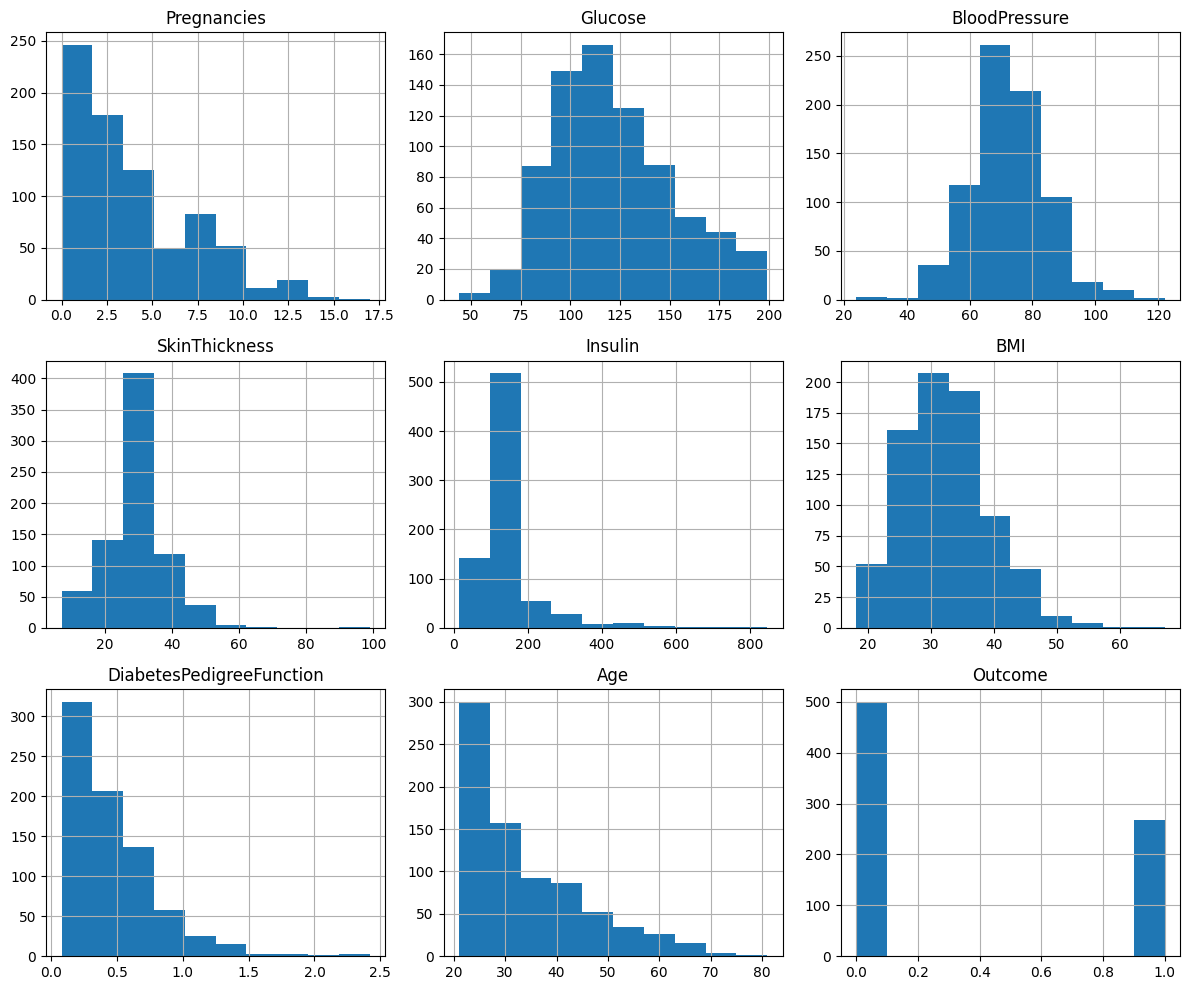

In [7]:
# Histograms of features
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


In [8]:
# Separate features and target variable
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


In [9]:
# Check class distribution
print("Class distribution:")
print(y.value_counts())


Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64


In [10]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [11]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)


In [12]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [13]:
# Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]


In [14]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72        99
           1       0.73      0.74      0.74       101

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200



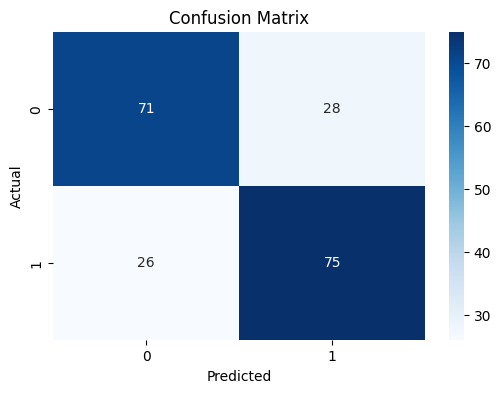

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


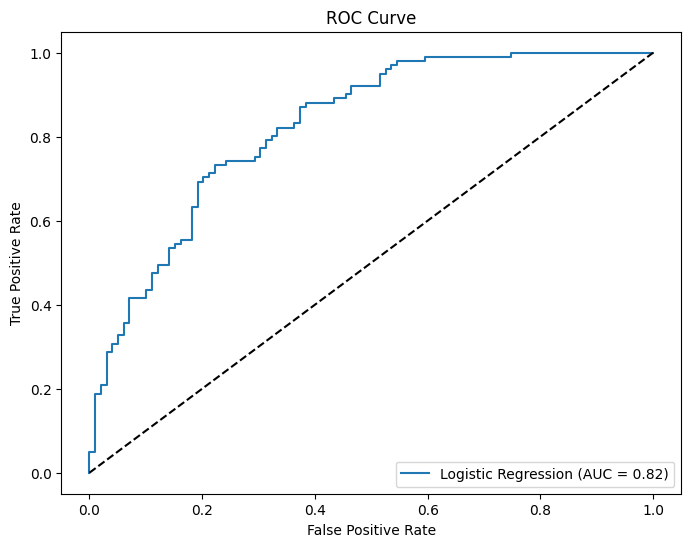

ROC AUC Score: 0.8241824182418241


In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Logistic Regression (AUC = %0.2f)" % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)


In [17]:
# Define parameter grid for GridSearchCV with compatible parameters
param_grid = [
    {
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    },
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
    }
]

# Initialize GridSearchCV with n_jobs=1 and cv=3 to limit resource usage
grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=3,           # Reduced from 5 to 3
    scoring='roc_auc',
    n_jobs=1,       # Limit to one processor
    verbose=1,
)

# Fit GridSearchCV
grid.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters:", grid.best_params_)

# Best estimator
best_model = grid.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [18]:
# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]


In [19]:
# Classification report
print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_best))


Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.74      0.73      0.73        99
           1       0.74      0.75      0.75       101

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200



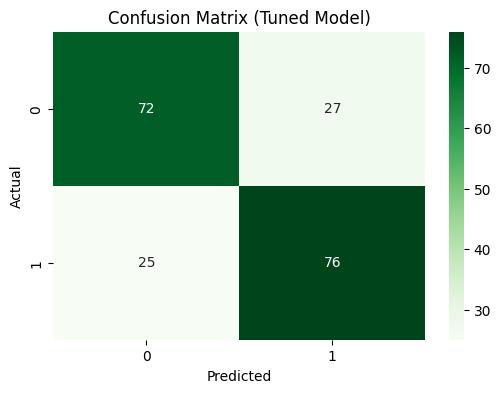

In [20]:
# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


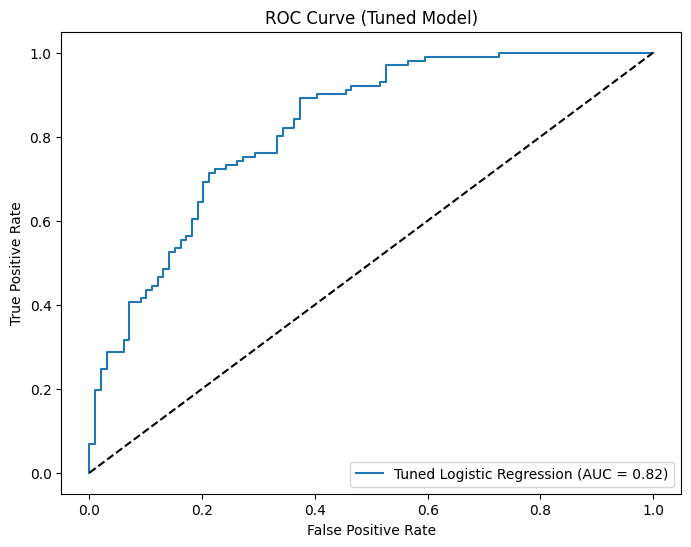

ROC AUC Score (Tuned Model): 0.8221822182218221


In [21]:
# ROC Curve
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(
    fpr_best,
    tpr_best,
    label="Tuned Logistic Regression (AUC = %0.2f)" % roc_auc_score(y_test, y_pred_proba_best),
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned Model)")
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC Score
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
print("ROC AUC Score (Tuned Model):", roc_auc_best)


In [22]:
# Cross-validation scores
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=3, scoring="accuracy")
print("Cross-validation Accuracy Scores:", cv_scores)
print("Mean Cross-validation Accuracy:", cv_scores.mean())


Cross-validation Accuracy Scores: [0.7245509  0.74174174 0.76276276]
Mean Cross-validation Accuracy: 0.7430184675693657


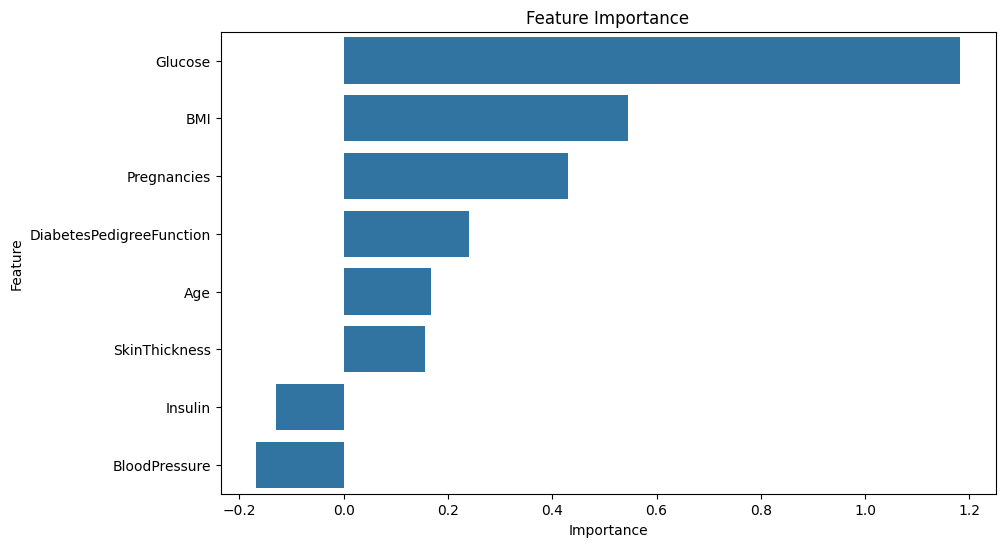

In [23]:
# Since Logistic Regression coefficients can indicate feature importance
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": best_model.coef_[0]}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()


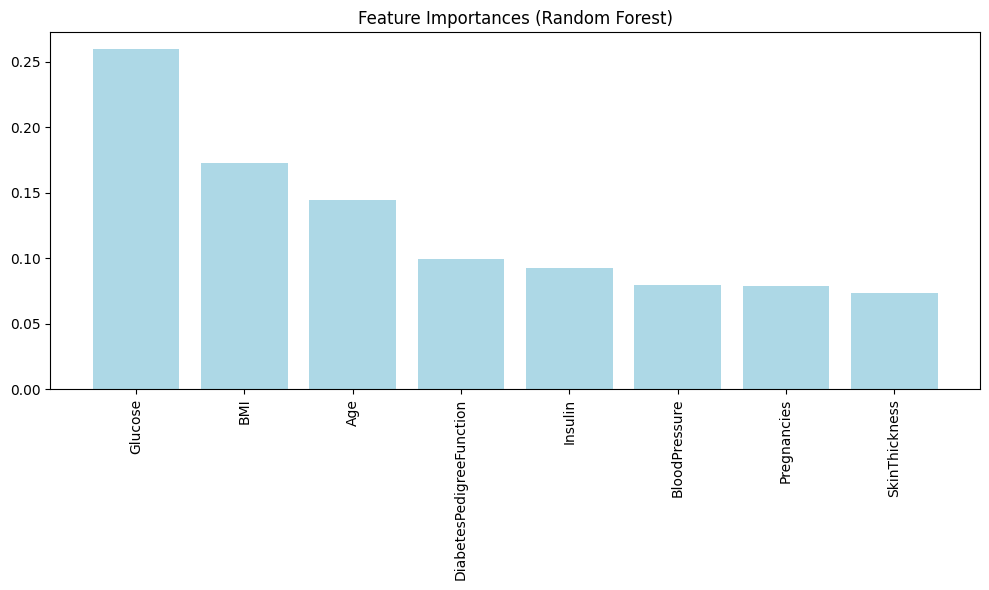

In [24]:
# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Feature importance from Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], color="lightblue", align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [25]:
# Import additional classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# If you want to use XGBoost
# !pip install xgboost
# from xgboost import XGBClassifier


In [26]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = None
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    return {
        "Model": model.__class__.__name__,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
    }


In [27]:
# List to store model performance
model_performance = []

# Logistic Regression (using the best model from GridSearchCV)
model_performance.append(
    evaluate_model(best_model, X_train, y_train, X_test, y_test)
)

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
model_performance.append(
    evaluate_model(rf_model, X_train, y_train, X_test, y_test)
)

# Support Vector Machine
svm_model = SVC(probability=True, random_state=42)
model_performance.append(
    evaluate_model(svm_model, X_train, y_train, X_test, y_test)
)

# K-Nearest Neighbors
knn_model = KNeighborsClassifier()
model_performance.append(
    evaluate_model(knn_model, X_train, y_train, X_test, y_test)
)

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
model_performance.append(
    evaluate_model(dt_model, X_train, y_train, X_test, y_test)
)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
model_performance.append(
    evaluate_model(gb_model, X_train, y_train, X_test, y_test)
)

# If using XGBoost
# xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# model_performance.append(
#     evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
# )


In [28]:
# Create a DataFrame to display the performance metrics
performance_df = pd.DataFrame(model_performance)
performance_df.set_index("Model", inplace=True)

# Display the performance table
display(performance_df)


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
LogisticRegression,0.740,0.737864,0.752475,0.745098,0.822182
RandomForestClassifier,0.780,0.756757,0.831683,0.792453,0.877988
SVC,0.795,0.754237,0.881188,0.812785,0.837284
KNeighborsClassifier,0.820,0.760000,0.940594,0.840708,0.848685
DecisionTreeClassifier,0.745,0.755102,0.732673,0.743719,0.745125
GradientBoostingClassifier,0.770,0.752294,0.811881,0.780952,0.838784


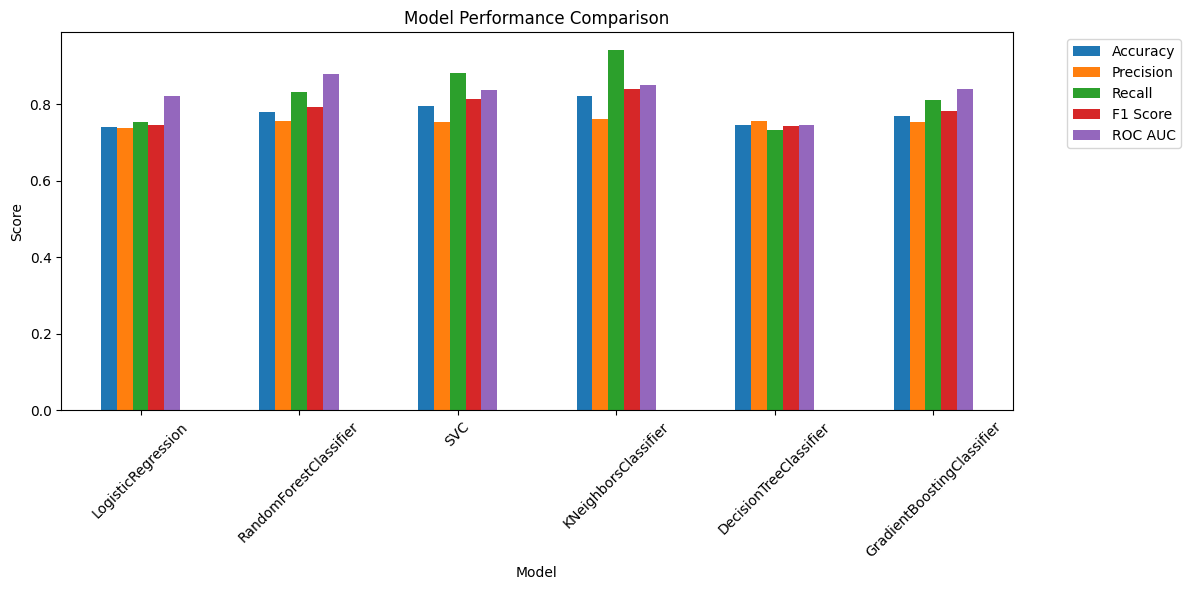

In [29]:
# Plot the performance metrics
performance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
# Sort the performance DataFrame by Accuracy
performance_df_sorted = performance_df.sort_values(by='Accuracy', ascending=False)
display(performance_df_sorted)


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
KNeighborsClassifier,0.820,0.760000,0.940594,0.840708,0.848685
SVC,0.795,0.754237,0.881188,0.812785,0.837284
RandomForestClassifier,0.780,0.756757,0.831683,0.792453,0.877988
GradientBoostingClassifier,0.770,0.752294,0.811881,0.780952,0.838784
DecisionTreeClassifier,0.745,0.755102,0.732673,0.743719,0.745125
LogisticRegression,0.740,0.737864,0.752475,0.745098,0.822182


In [31]:
# Example: Hyperparameter tuning for Random Forest
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Initialize RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    random_state=42,
)

# Fit RandomizedSearchCV
rf_random_search.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters for Random Forest:", rf_random_search.best_params_)

# Best estimator
best_rf_model = rf_random_search.best_estimator_


Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 20}


In [32]:
# Evaluate the best Random Forest model
rf_performance = evaluate_model(best_rf_model, X_train, y_train, X_test, y_test)
print("Performance of the Best Random Forest Model:")
print(rf_performance)


Performance of the Best Random Forest Model:
{'Model': 'RandomForestClassifier', 'Accuracy': 0.795, 'Precision': 0.7777777777777778, 'Recall': 0.8316831683168316, 'F1 Score': 0.8038277511961722, 'ROC AUC': 0.87998799879988}


In [33]:
# # Save the best model
# joblib.dump(best_rf_model, 'best_diabetes_model.pkl')
# print("Best model saved successfully.")


In [34]:
# Load the best model
loaded_best_model = joblib.load('best_diabetes_model.pkl')

# Update the prediction function
def predict_diabetes(input_data):
    """
    Predict diabetes using the loaded best model.
    input_data: List or array of input features in the following order:
        [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age]
    """
    # Create a DataFrame
    input_df = pd.DataFrame([input_data], columns=X.columns)
    
    # Preprocess 'Insulin' (apply log transformation)
    input_df["Insulin"] = input_df["Insulin"].apply(np.log1p)
    
    # Replace missing values if any
    for col in cols_with_zero:
        input_df[col] = input_df[col].replace(0, df[col].median())
    
    # Scale the input data
    input_scaled = loaded_scaler.transform(input_df)
    
    # Predict
    prediction = loaded_best_model.predict(input_scaled)
    if hasattr(loaded_best_model, "predict_proba"):
        prediction_proba = loaded_best_model.predict_proba(input_scaled)[:, 1]
    else:
        prediction_proba = None
    
    result = {
        "Prediction": int(prediction[0]),
        "Probability": prediction_proba[0] if prediction_proba is not None else None,
    }
    return result


In [35]:
from sklearn.model_selection import cross_val_score

models = [
    LogisticRegression(max_iter=1000, **grid.best_params_),
    RandomForestClassifier(random_state=42),
    SVC(probability=True, random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    # XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
]

model_names = [
    "Logistic Regression",
    "Random Forest",
    "SVM",
    "KNN",
    "Decision Tree",
    "Gradient Boosting",
    # "XGBoost",
]

cv_performance = []

for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_resampled, y_resampled, cv=3, scoring='accuracy', n_jobs=1)
    cv_performance.append({
        "Model": name,
        "Cross-Val Accuracy": scores.mean()
    })

cv_performance_df = pd.DataFrame(cv_performance)
display(cv_performance_df)


,Model,Cross-Val Accuracy
0,Logistic Regression,0.743018
1,Random Forest,0.821052
2,SVM,0.804056
3,KNN,0.788028
4,Decision Tree,0.745038
5,Gradient Boosting,0.796039


<Figure size 1000x600 with 0 Axes>

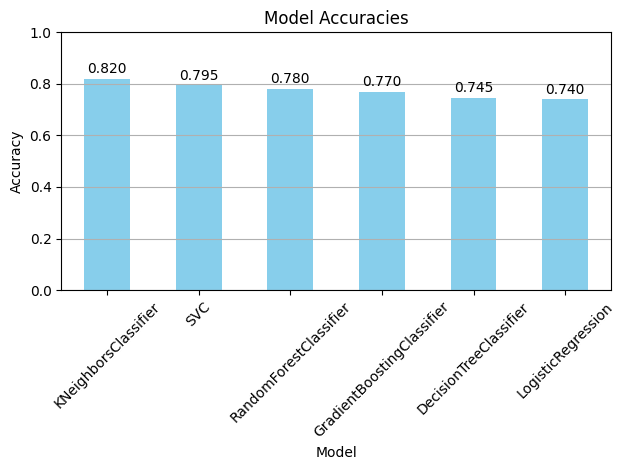

In [36]:
import matplotlib.pyplot as plt

# Assuming performance_df is already created and has the accuracies
# If not, here's how you might create it:

# performance_df = pd.DataFrame(model_performance)
# performance_df.set_index("Model", inplace=True)

# Extract the accuracies
accuracy_df = performance_df[['Accuracy']].copy()

# Optional: Sort the models by accuracy
accuracy_df_sorted = accuracy_df.sort_values(by='Accuracy', ascending=False)

# Plotting the accuracies
plt.figure(figsize=(10, 6))
accuracy_df_sorted.plot(kind='bar', legend=False, color='skyblue')
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim([0, 1])  # Set y-axis limits between 0 and 1
plt.grid(axis='y')

# Adding accuracy values on top of each bar
for index, value in enumerate(accuracy_df_sorted['Accuracy']):
    plt.text(index, value + 0.01, f"{value:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [37]:
# Get feature importances from the model
importances = best_rf_model.feature_importances_
feature_names = X.columns  # Assuming X is your DataFrame of features


In [38]:
# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


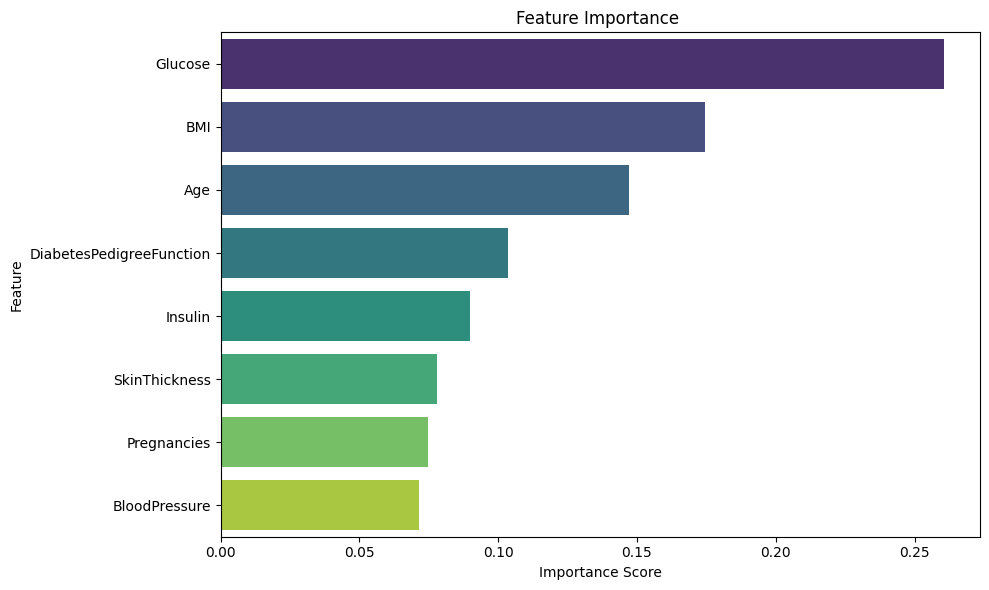

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a barplot
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

# Add plot labels and titles
plt.title('Feature Importance ')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# Show the plot
plt.tight_layout()
plt.show()


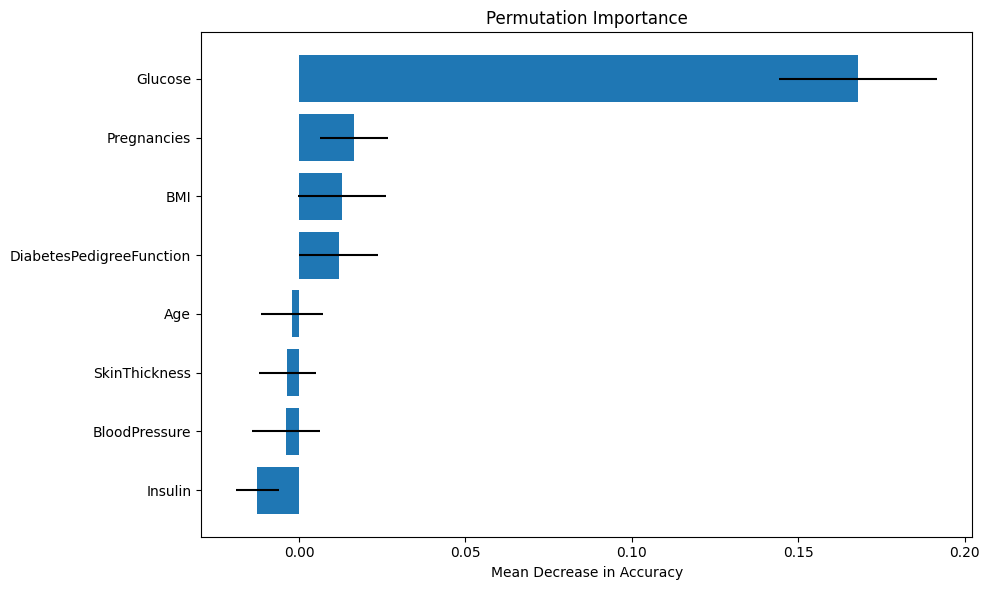

In [40]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 1. Compute permutation importances
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1
)

importances = result.importances_mean
importances_std = result.importances_std
feature_names = X.columns

# 2. Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Std': importances_std
})

# 3. Sort the DataFrame
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], xerr=feature_importance_df['Std'])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Importance')
plt.tight_layout()
plt.show()
